In [1]:
import torch
import nntools as nt
from models import generator,discriminator
import matplotlib.pyplot as plt
import torchvision
import imageio
import numpy as np
from models import feature_axis

In [2]:
from train import *

In [3]:
exp1.load()

In [4]:
noise1 = torch.randn(8, args["nz"], 1, 1, device=device)
noise2 = torch.ones(8, args["nz"], 1, 1, device=device)
# delta = (noise2-noise1)/10


In [5]:
# filenames = []
# for i in range(10):
#     img_gen = generator_(noise1 + i*0.4*noise2)
# #     img_gen = generator_(noise1 + i*delta)
#     torchvision.utils.save_image(img_gen.detach(),f'./test{i}_del.png',normalize=True)
#     filenames.append(f'./test{i}_del.png')
    
# images = []
# kargs = { 'duration': 1 }
# for filename in filenames:
#     images.append(imageio.imread(filename))
# imageio.mimsave('test.gif', images, 'GIF', **kargs)

In [6]:
import torch.nn.functional as F
classifierCheckpoint = torch.load('./results/classifier')

from models import classifier
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

extractor = classifier.Extractor().to(device)
emotion_classifier = classifier.Classifier(7).to(device)
gender_classifier = classifier.Classifier(2).to(device)

extractor.load_state_dict(classifierCheckpoint['extractor'])
emotion_classifier.load_state_dict(classifierCheckpoint['emotion_classifier'])
gender_classifier.load_state_dict(classifierCheckpoint['gender_classifier'])

extractor.eval()
emotion_classifier.eval()
gender_classifier.eval()

def getProbabilities(generatedImages):

    feature = extractor.forward(generatedImages).squeeze()

    gender_output = gender_classifier.forward(feature)
    emotion_output = emotion_classifier.forward(feature)

    gender_probs = F.softmax(gender_output, dim=1)
    emotion_probs = F.softmax(emotion_output, dim=1)
    #print(emotion_probs)
    return emotion_probs
    values = emotion_probs[:,feature_exp]
    
    return values

anger


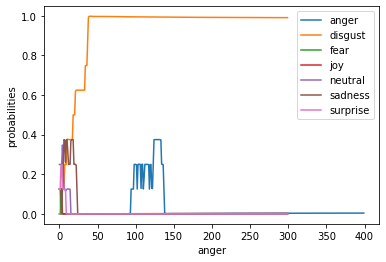

disgust


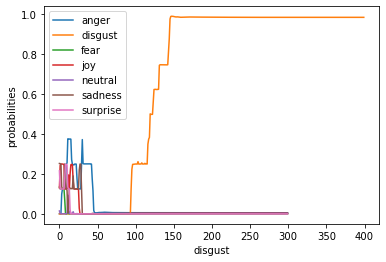

fear


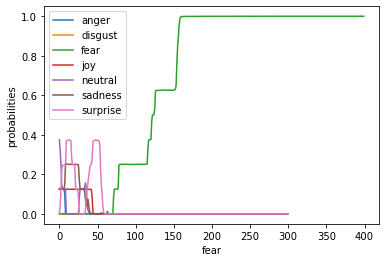

joy


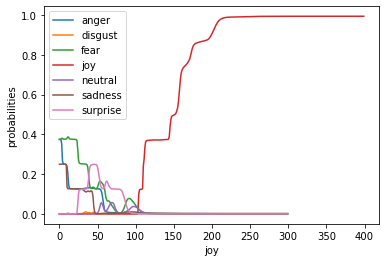

neutral


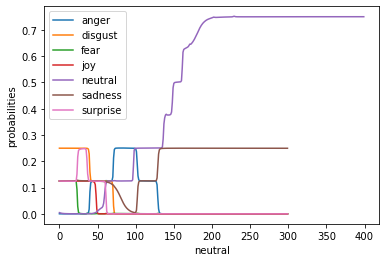

sadness


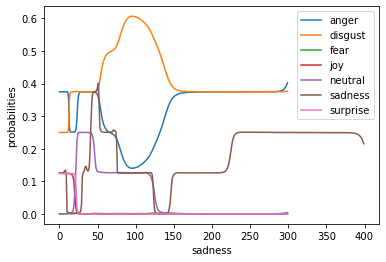

surprise


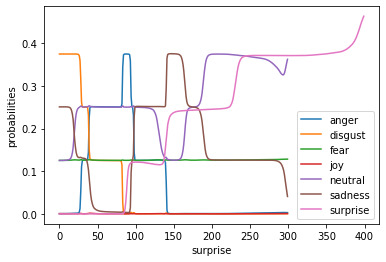

In [7]:
{
		'anger' : 0,
		'disgust' : 1,
		'fear' : 2,
		'joy' : 3,
		'neutral' : 4,
		'sadness' : 5,
		'surprise' : 6,
        'female' : 7,
        'male' : 8,
}

d = {
    0 : 'anger',
    1 : 'disgust',
    2 : 'fear',
    3 : 'joy',
    4 : 'neutral',
    5 : 'sadness',
    6 : 'surprise',
    7 : 'female',
    8 : 'male'
}


coeff = np.load('./data/coefficients_tanh_jules.npy')
coeff = feature_axis.normalize_feature_axis(coeff)
len_z, len_y = coeff.shape
coeff = feature_axis.disentangle_feature_axis_by_idx(coeff, idx_base=range(len_y), idx_target=None)
coeff = feature_axis.normalize_feature_axis(coeff)
# a = np.corrcoef(coeff.T)
# print(a)

feature_exp = 3
all_features = [0,1,2,3,4,5,6]
for feature_exp in all_features:
    print(d[feature_exp])
    feature_direction = coeff / np.linalg.norm(coeff, ord=2, axis=0, keepdims=True)
    delta = torch.Tensor(feature_direction[:,feature_exp]).to(device)
    delta = delta.unsqueeze(1).unsqueeze(1).unsqueeze(0).expand(8,100,1,1)
    noise1 = torch.randn(8, args["nz"], 1, 1, device=device)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    filenames = []
    tupleOfProbs = ()
    tupleOfProbsList = [(),(),(),(),(),(),()]
    for i in range(100):
        img_gen = generator_(noise1 - i*0.1*delta)
        emotion_probs = getProbabilities(img_gen)
        for j in all_features:
            if(j == feature_exp):
                probs = emotion_probs[:,j]
                tupleOfProbsList[j] = (probs.unsqueeze(1),) + tupleOfProbsList[j]
        torchvision.utils.save_image(img_gen.detach(),f'./test{i}_back_del.png',normalize=True)
        filenames = [f'./test{i}_back_del.png'] + filenames
        #filenames.append(f'./test{i}_back_del.png')
        
    for i in range(300):
        img_gen = generator_(noise1 + i*0.1*delta)
        emotion_probs = getProbabilities(img_gen)
        for j in all_features:
            if(j == feature_exp or True):
                probs = emotion_probs[:,j]
                tupleOfProbsList[j] = tupleOfProbsList[j] + (probs.unsqueeze(1),)
        torchvision.utils.save_image(img_gen.detach(),f'./test{i}_forward_del.png',normalize=True)
        filenames.append(f'./test{i}_forward_del.png')
    
    import matplotlib.pyplot as plt
    plt.figure()
    plt.xlabel(d[feature_exp])
    plt.ylabel('probabilities')
    for j in all_features:
        if(j == feature_exp or True):
            allProbs = torch.cat(tupleOfProbsList[j], 1)
            a = np.mean(allProbs.T.cpu().detach().numpy(), axis=1)
            plt.plot(a)
    plt.gca().legend(('anger','disgust','fear','joy','neutral','sadness','surprise'))
    
    plt.show()

    imagesStart = False
    concatenatedImages = []
    images = []
    kargs = { 'duration': 0.1 }
    for filename in filenames:
        images.append(imageio.imread(filename))
#     for filename in filenames:
#         if(imagesStart == False):
#             concatenatedImages = imageio.imread(filename)
#             imagesStart = True
#         else:
#             concatenatedImages = np.concatenate((concatenatedImages, imageio.imread(filename)), axis=0)
#     import matplotlib.pyplot as plt
#     #plt.imshow(concatenatedImages)q
    imageio.mimsave('test_'+d[feature_exp]+'.gif', images, 'GIF', **kargs)

In [8]:
for i in range(9):
    for j in range(9):
        a = np.dot(coeff[:,i], coeff[:,j])/np.sqrt((np.sum(coeff[:,i]**2)*np.sum(coeff[:,j]**2)))
        print((d[i],d[j],a))

('anger', 'anger', 1.0)
('anger', 'disgust', -4.5401976e-09)
('anger', 'fear', 3.1897798e-08)
('anger', 'joy', 1.661283e-08)
('anger', 'neutral', 3.3833203e-08)
('anger', 'sadness', 4.8050424e-08)
('anger', 'surprise', 2.1979213e-07)
('anger', 'female', -6.532355e-08)
('anger', 'male', -1.6530976e-08)
('disgust', 'anger', -4.5401976e-09)
('disgust', 'disgust', 1.0)
('disgust', 'fear', 4.2258762e-08)
('disgust', 'joy', 4.2971802e-08)
('disgust', 'neutral', 9.423819e-08)
('disgust', 'sadness', 9.755604e-08)
('disgust', 'surprise', 3.757304e-07)
('disgust', 'female', -7.4980555e-08)
('disgust', 'male', -1.9590516e-08)
('fear', 'anger', 3.1897798e-08)
('fear', 'disgust', 4.2258762e-08)
('fear', 'fear', 1.0)
('fear', 'joy', -2.9336661e-08)
('fear', 'neutral', -2.0838343e-08)
('fear', 'sadness', -1.21071935e-08)
('fear', 'surprise', -8.882489e-08)
('fear', 'female', -1.1994416e-08)
('fear', 'male', 4.48199e-09)
('joy', 'anger', 1.661283e-08)
('joy', 'disgust', 4.2971802e-08)
('joy', 'fear', 

In [9]:
def getProbabilities(generatedImages, feature_exp):
    classifierCheckpoint = torch.load('./results/classifier')

	from models import classifier
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

	extractor = classifier.Extractor().to(device)
	emotion_classifier = classifier.Classifier(7).to(device)
	gender_classifier = classifier.Classifier(2).to(device)

	extractor.load_state_dict(classifierCheckpoint['extractor'])
	emotion_classifier.load_state_dict(classifierCheckpoint['emotion_classifier'])
	gender_classifier.load_state_dict(classifierCheckpoint['gender_classifier'])

	extractor.eval()
	emotion_classifier.eval()
	gender_classifier.eval()
    
    feature = extractor.forward(images).squeeze()
    
	gender_output = gender_classifier.forward(feature)
	emotion_output = emotion_classifier.forward(feature)

	gender_probs = F.softmax(gender_output, dim=1)
	emotion_probs = F.softmax(emotion_output, dim=1)
    
    values = emotion_probs[:,feature_exp]
    
    print(values)

TabError: inconsistent use of tabs and spaces in indentation (<ipython-input-9-e9fbad23fa48>, line 4)